In [1]:
# Classical Gram–Schmidt (Trefethen algorithm 7.1), implemented in the simplest way
# (We could make it faster by unrolling loops to avoid temporaries arrays etc.)
function clgs(A)
    m,n = size(A)
    Q = similar(A)
    R = zeros(eltype(A),n,n)
    for j = 1:n
        aⱼ = A[:,j]
        vⱼ = copy(aⱼ) # use copy so that modifying vⱼ doesn't change aⱼ
        for i = 1:j-1
            qᵢ = Q[:,i]
            R[i,j] = dot(qᵢ, aⱼ)
            vⱼ -= R[i,j] * qᵢ
        end
        R[j,j] = norm(vⱼ)
        Q[:,j] = vⱼ / R[j,j]
    end
    return Q, R
end

# Modified Gram–Schmidt (Trefethen algorithm 8.1)
function mgs(A)
    m,n = size(A)
    Q = similar(A)
    R = zeros(eltype(A),n,n)
    for j = 1:n
        aⱼ = A[:,j]
        vⱼ = copy(aⱼ)
        for i = 1:j-1
            qᵢ = Q[:,i]
            R[i,j] = dot(qᵢ, vⱼ) # ⟵ NOTICE: mgs has vⱼ, clgs has aⱼ
            vⱼ -= R[i,j] * qᵢ
        end
        R[j,j] = norm(vⱼ)
        Q[:,j] = vⱼ / R[j,j]
    end
    return Q, R
end

mgs (generic function with 1 method)

# Gram-Schmidt: Stability

## Comparing classical to modified Gram-Schmidt

Here we experiment to see the differences between classical GS and MGS in a numerical implementation. We start by constructing a matrix with exponentially decreasing singular values.

In [2]:
(U,s,V) = svd(randn(80,80));
s = 2.0.^(-1:-1:-80);
A = U*diagm(s)*V';
(Qc,Rc) = clgs(A);  # classical
(Qm,Rm) = mgs(A); # modified

(
[0.158626 -0.0199175 … -0.252481 -0.111434; 0.154511 0.0852774 … -0.127434 0.013003; … ; -0.0893181 -0.11689 … -0.0684063 0.0818045; -0.017071 0.0197329 … -0.0689986 -0.0150727],

[0.0589685 0.00847436 … -0.00476951 -0.00925246; 0.0 0.0108227 … -0.019678 -0.0328969; … ; 0.0 0.0 … 7.01746e-18 3.1408e-18; 0.0 0.0 … 0.0 7.61643e-18])

We expect the diagonal entries of the $R$ in a QR factorization of $A$ to be close to the singular values of $A$. 

In [3]:
using PyPlot
n = size(A,2)

80

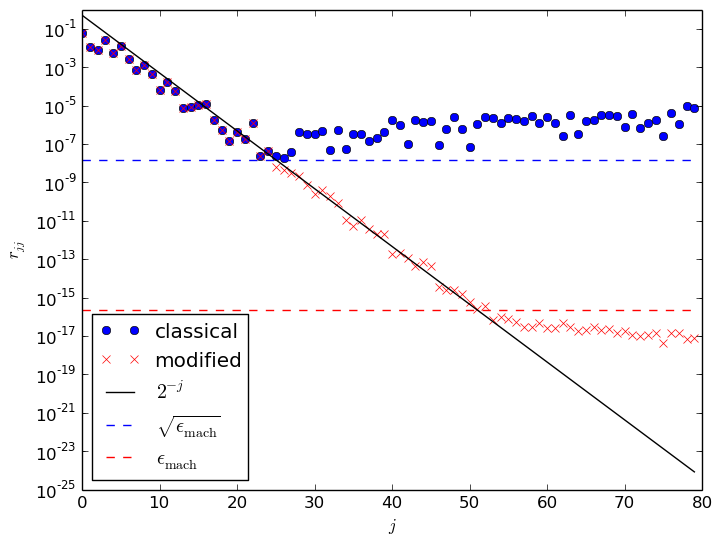

PyObject <matplotlib.text.Text object at 0x7fc95801c910>

In [4]:
semilogy(diag(Rc), "bo")
semilogy(diag(Rm), "rx")
semilogy(2.0 .^ -(1:n), "k-")
semilogy(ones(n)*sqrt(eps()), "b--"); semilogy(ones(n)*eps(), "r--")
legend(["classical","modified",L"2^{-j}", L"\sqrt{\epsilon_\mathrm{mach}}", L"\epsilon_\mathrm{mach}"], loc="lower left")
ylabel(L"r_{jj}"); xlabel(L"j")

The modified version stays close to the line until around $10^{-16}$. This is the limit of machine precision. In the classical case the departure is closer to $10^{-8}$. We can get a little more information by recasting the problem into "single precision," which has a limit of about $10^{-8}$ relative precision. 

In [10]:
A = convert(Array{Float32},A);
(Qc,Rc) = clgs(A);  # classical
(Qm,Rm) = mgs(A); # modified

(
Float32[0.707107 0.0; 0.707107 -1.0],

Float32[4.44288 2.0; 0.0 1.19209f-7])

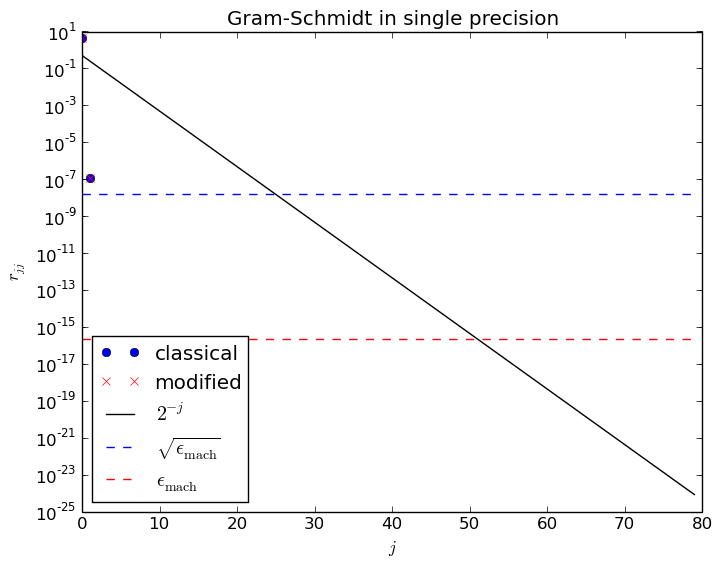

PyObject <matplotlib.text.Text object at 0x7fc957a02bd0>

In [11]:
semilogy(diag(Rc), "bo")
semilogy(diag(Rm), "rx")
semilogy(2.0 .^ -(1:n), "k-")
semilogy(ones(n)*sqrt(eps()), "b--"); semilogy(ones(n)*eps(), "r--")
legend(["classical","modified",L"2^{-j}", L"\sqrt{\epsilon_\mathrm{mach}}", L"\epsilon_\mathrm{mach}"], loc="lower left")
ylabel(L"r_{jj}"); xlabel(L"j")
title("Gram-Schmidt in single precision")

A reasonable hypothesis (based on two data points) is that roundoff at precision $\epsilon$ affects MGS at the level $O(\epsilon)$, but classical GS at $O(\sqrt{\epsilon})$. 

## Loss of orthogonality

A different sort of instability remains in the MGS algorithm. It can be seen in a $2\times 2$ toy example. This example is constructed using the principle: the columns of $A$ are _nearly_ parallel.

In [7]:
A = [pi sqrt(2); 355/113 sqrt(2)];

When we subtract off the projection of the second column onto the first, the remainder is quite small (relative to the original components). 

In [8]:
Q = A[:,1]/norm(A[:,1]);
v = A[:,2] - Q[:,1]*Q[:,1]'*A[:,2]

2-element Array{Float64,1}:
  6.0043e-8
 -6.0043e-8

Of the original 16 significant digits, about 7 have been canceled out in subtraction.

In [9]:
Q = [ Q v/norm(v)];
norm(Q'*Q - eye(2))

1.9202538448226425e-9

Much later, when we start doing iterative methods, we'll be coming back to the MGS algorithm. This loss of orthogonality is so important that practical implementations take measures to re-orthogonalize their results regularly. 